In [42]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import norm
import tqdm

import torch
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_pil_image
from torchvision.io import read_image
from torchvision import transforms
from PIL import Image
from collections import Counter

import os
import sys
import json
import random as rnd

In [43]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from models.autoencoder import ConvAutoencoder
from training.data_processor import DataProcessor
from training.config import IMAGE_SIZE, MANUAL_SEED, BATCH_SIZE, TRAIN_VAL_TEST_SPLIT

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Device: cuda


1. visualize autoencoder training

In [44]:
METRICS_PATH = "../results/metrics_autoencoder_a1_full_ds(25-11_06-58).json"
metrics_df = pd.read_json(METRICS_PATH)
n = len(metrics_df)
epochs = list(range(n))
metrics_df

,train_loss,val_loss
0,3.670621,1.108157
1,1.569218,1.053047
2,1.349983,0.998221
3,1.248844,0.913477
4,1.154465,0.816428
5,1.092013,0.792680
6,1.029105,0.756610
7,1.049727,0.729217
8,0.967546,0.704186
9,0.925144,0.685055


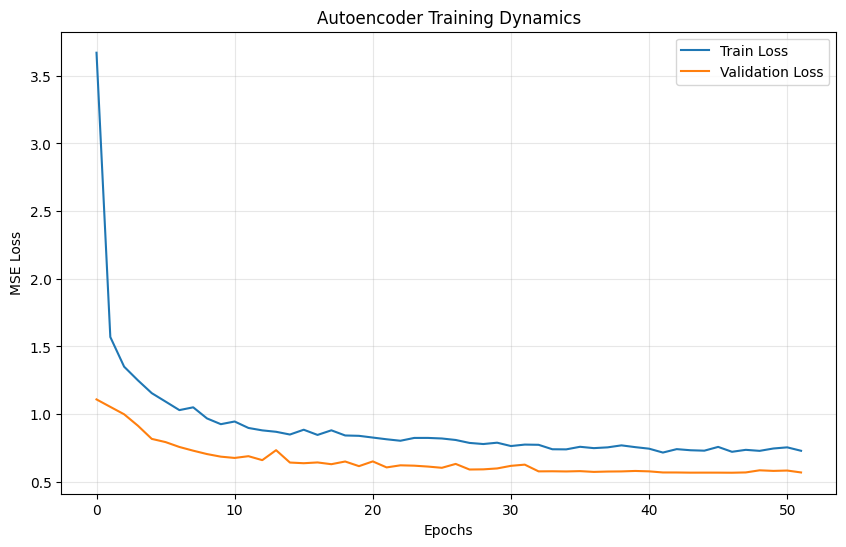

In [45]:
plt.figure(figsize=(10, 6))
plt.plot(metrics_df["train_loss"], label="Train Loss")
plt.plot(metrics_df["val_loss"], label="Validation Loss")
plt.title("Autoencoder Training Dynamics")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [92]:
CHECKPOINT_PATH = "../checkpoints/checkpoint_autoencoder_a1(25-11_05-52).pth" 

model = ConvAutoencoder().to(device)

checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

processor = DataProcessor(
    data_path="../data",
    image_size=IMAGE_SIZE,
    train_val_test_split=TRAIN_VAL_TEST_SPLIT,
    manual_seed=MANUAL_SEED
)

train_ds, _, test_ds = processor.process(batch_size=BATCH_SIZE)

print(f"Dataset size for analysis: {len(test_ds)}")
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=False)

Dataset size for analysis: 299


2. Anomaly detection

In [83]:
results = [] 
val_losses = []

criterion = torch.nn.MSELoss(reduction='none')

print("Collecting reconstruction errors...")
with torch.no_grad():
    for images, labels in tqdm.tqdm(test_loader):
        images = images.to(device)
        reconstructed = model(images)
        losses = criterion(reconstructed, images).mean(dim=[1, 2, 3])
        
        for i in range(len(images)):
            loss_val = losses[i].item()
            label_val = labels[i].item()
            
            results.append({
                "loss": loss_val,
                "image": images[i].cpu(),
                "recon": reconstructed[i].cpu(),
                "label": label_val
            })
            val_losses.append(loss_val)

val_losses = np.array(val_losses)
mu = np.mean(val_losses)
sigma = np.std(val_losses)

trsh = 2.3
threshold = mu + trsh * sigma 

print(f"Mean Loss (mu): {mu:.5f}")
print(f"Std Dev (sigma): {sigma:.5f}")
print(f"Anomaly Threshold (mu + {trsh}*sigma): {threshold:.5f}")

100%|██████████| 19/19 [00:01<00:00,  9.96it/s]

Mean Loss (mu): 0.65125
Std Dev (sigma): 0.35360
Anomaly Threshold (mu + 2.3*sigma): 1.46454


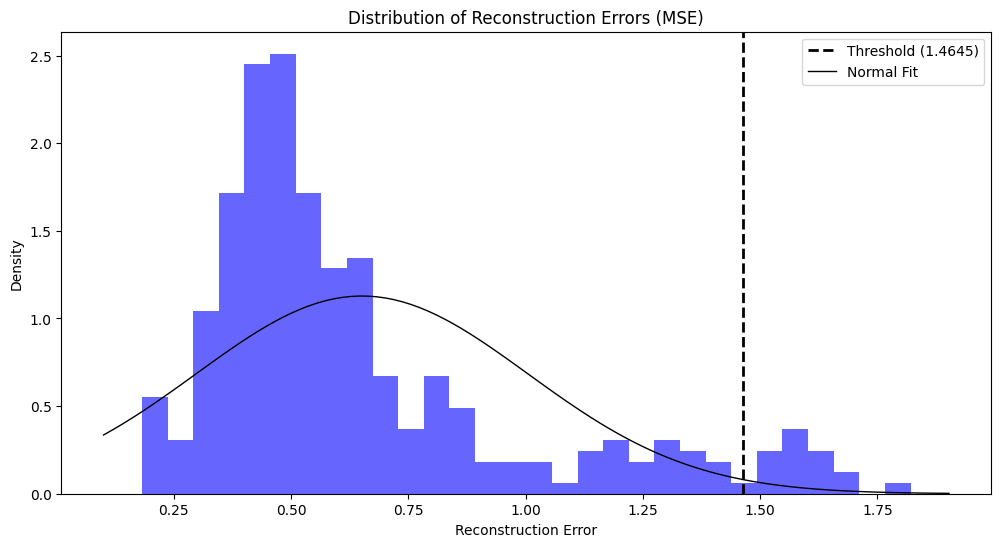

In [84]:
plt.figure(figsize=(12, 6))
plt.hist(val_losses, bins=30, alpha=0.6, color='blue', density=True)

# trashhold
plt.axvline(threshold, color='black', linestyle='--', linewidth=2, label=f'Threshold ({threshold:.4f})')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, sigma)
plt.plot(x, p, 'k', linewidth=1, label='Normal Fit')

plt.title("Distribution of Reconstruction Errors (MSE)")
plt.xlabel("Reconstruction Error")
plt.ylabel("Density")
plt.legend()
plt.show()

Found 17 anomalies out of 299 test images.


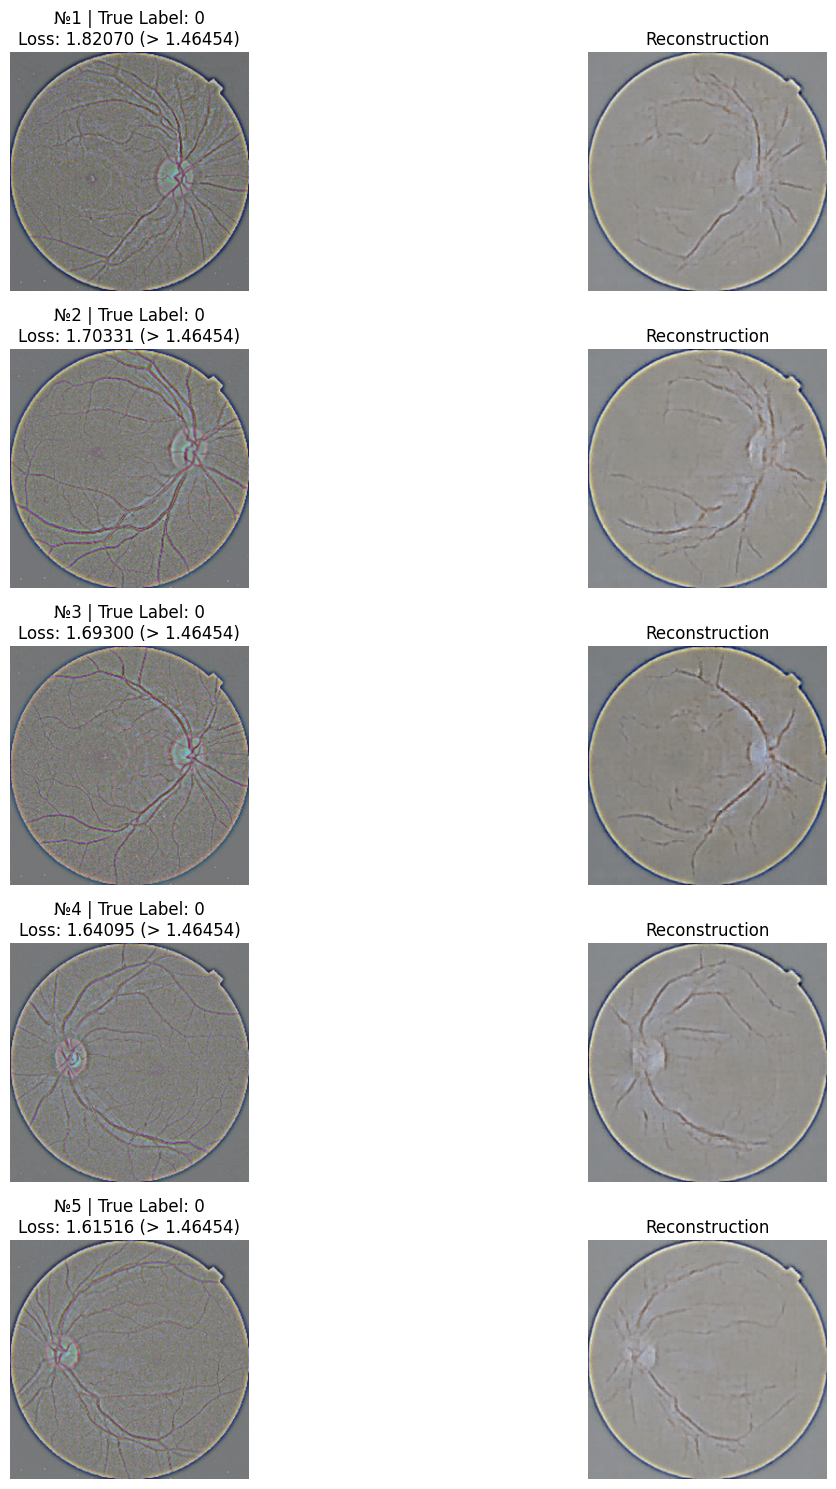

In [ ]:
anomalies = [r for r in results if r["loss"] > threshold]
anomalies.sort(key=lambda x: x["loss"], reverse=True)
print(f"Found {len(anomalies)} anomalies out of {len(results)} test images.")

def show_anomalies_grid(anomalies, max_show=5):
    if not anomalies:
        return

    n = min(len(anomalies), max_show)
    plt.figure(figsize=(15, 3 * n))
    
    for i in range(n):
        sample = anomalies[i]

        # original
        ax = plt.subplot(n, 2, 2*i + 1)
        img = sample["image"].permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max() - img.min())
        plt.imshow(img)
        plt.title(f"№{i+1} | True Label: {sample['label']}\nLoss: {sample['loss']:.5f} (> {threshold:.5f})")
        plt.axis("off")

        # reconstructed
        ax = plt.subplot(n, 2, 2 * i + 2)
        recon = sample["recon"].permute(1, 2, 0).numpy()
        recon = (recon - recon.min()) / (recon.max() - recon.min())
        plt.imshow(recon)
        plt.title(f"Reconstruction")
        plt.axis("off")
        
    plt.tight_layout()
    plt.show()

show_anomalies_grid(anomalies, max_show=5)

3. latent space visualization

100%|██████████| 87/87 [00:05<00:00, 16.87it/s]


Fitting t-SNE


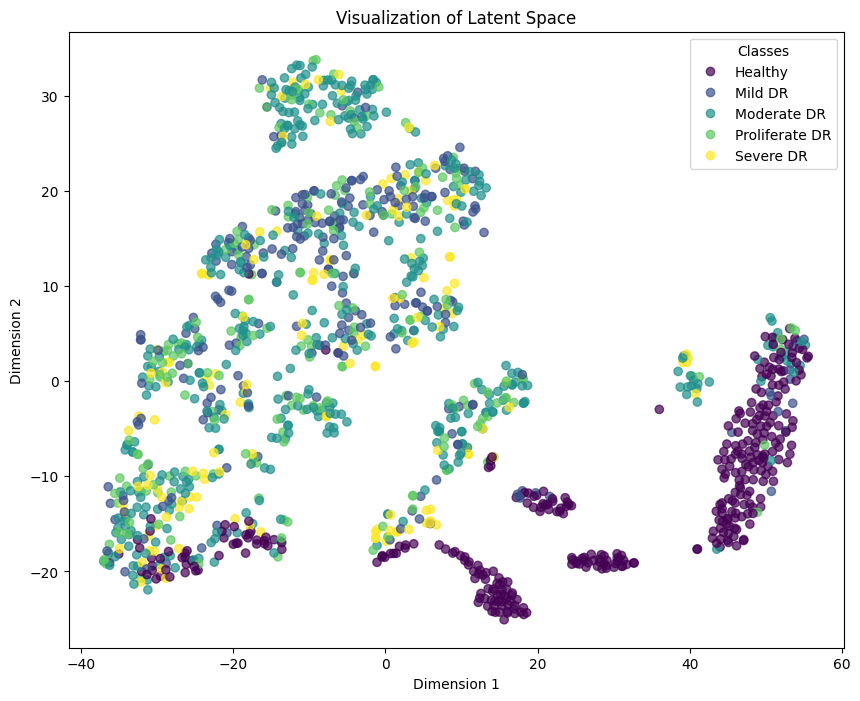

In [96]:
embeddings = []
targets = []

with torch.no_grad():
    for images, labels in tqdm.tqdm(train_loader):
        images = images.to(device)
        emb = model.get_embedding(images)
        embeddings.append(emb.cpu().numpy())
        targets.extend(labels.numpy())

embeddings = np.concatenate(embeddings, axis=0)
targets = np.array(targets)

# t-SNE
print("Fitting t-SNE")
tsne = TSNE(n_components=2, random_state=MANUAL_SEED, perplexity=50, max_iter=3000)
tsne_results = tsne.fit_transform(embeddings)

# visualize
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=targets, cmap='viridis', alpha=0.7)
plt.title("Visualization of Latent Space")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")

classes = ["Healthy", "Mild DR", "Moderate DR", "Proliferate DR", "Severe DR"]
plt.legend(handles=scatter.legend_elements()[0], labels=classes, title="Classes")
plt.show()